In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#for NLP
import nltk
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing


In [23]:
# General stopwords & vectorizer
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = CountVectorizer(stop_words = stopwords, ngram_range=(1,2))

In [24]:
#Kaggle Data import
df = pd.read_csv("Emotion_final.csv")

targets = df["Emotion"]
corpus = df["Text"]

# Vobabulary analysis
vec = TfidfVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus)
words = vec.get_feature_names()

#Prepocessing
le = preprocessing.LabelEncoder()
le.fit(targets)
y = le.transform(targets)

In [25]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [26]:
X

<21459x19070 sparse matrix of type '<class 'numpy.float64'>'
	with 193564 stored elements in Compressed Sparse Row format>

# PCA with Pipeline

In [27]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [36]:
def bench_k_means(kmeans, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(with_mean=False), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [ metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean", ) ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [37]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english')
tf_idf = tf_idf_vectorizor.fit_transform(corpus)

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=6, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=y)

kmeans = KMeans(init="random", n_clusters=6, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=y)

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(corpus)

clf = TruncatedSVD()
Xpca = clf.fit_transform(tf_idf)
XX = PCA(2).fit_transform(Xpca)
kmeans = KMeans(n_clusters=6, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=XX, labels=y)
from sklearn.feature_extraction.text import TfidfVectorizer
print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.348s	408589134	0.000	0.173	0.001	0.000	0.000	-0.003
random   	0.555s	409038758	0.000	0.076	0.001	-0.000	0.000	-0.005
PCA-based	0.050s	8324	0.003	0.003	0.003	0.003	0.003	0.360
__________________________________________________________________________________


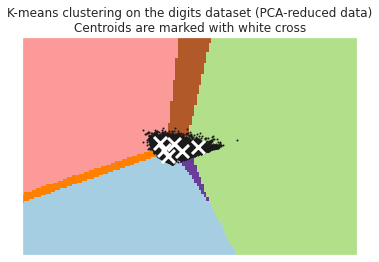

In [44]:
#Visualize the results on PCA-reduced data
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(XX)
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()